In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import sys
import os

sys.path.append(os.path.abspath("../src"))
from volatility_detection import get_regime

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

C:\Users\james\AppData\Local\Temp\ipykernel_9944\1239871694.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [42]:
# Download data
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Download VXN (NASDAQ-100 Volatility Index) and NASDAQ data
vxn = yf.download('^VXN', start=start_date, end=end_date)
nasdaq = yf.download('^IXIC', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [43]:
# Synchronize indices
common_dates = vxn.index.intersection(nasdaq.index)
vxn = vxn.loc[common_dates]
nasdaq = nasdaq.loc[common_dates]

# Extract 1D Series from 'Adj Close' columns
vxn_adj_close = vxn['Adj Close'].squeeze()
nasdaq_adj_close = nasdaq['Adj Close'].squeeze()

In [44]:
# Create DataFrame with both VXN and NASDAQ
df = pd.DataFrame({
    'VXN': vxn_adj_close,
    'NASDAQ': nasdaq_adj_close
}, index=common_dates)

# Calculate returns
df['NASDAQ_Returns'] = df['NASDAQ'].pct_change()


In [45]:
# Define market regimes based on VXN levels
# Note: VXN typically runs slightly higher than VIX, so adjusting thresholds
df['Regime'] = df['VXN'].apply(get_regime)

In [46]:
# Calculate regime statistics
regime_stats = df.groupby('Regime')['NASDAQ_Returns'].agg([
    'mean', 'std', 'count'
]).round(4)

regime_stats['annualized_return'] = regime_stats['mean'] * 252 * 100
regime_stats['annualized_volatility'] = regime_stats['std'] * np.sqrt(252) * 100



C:\Users\james\AppData\Local\Temp\ipykernel_9944\1278368641.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[mask]['NASDAQ_Returns'],


<Figure size 1500x1000 with 0 Axes>

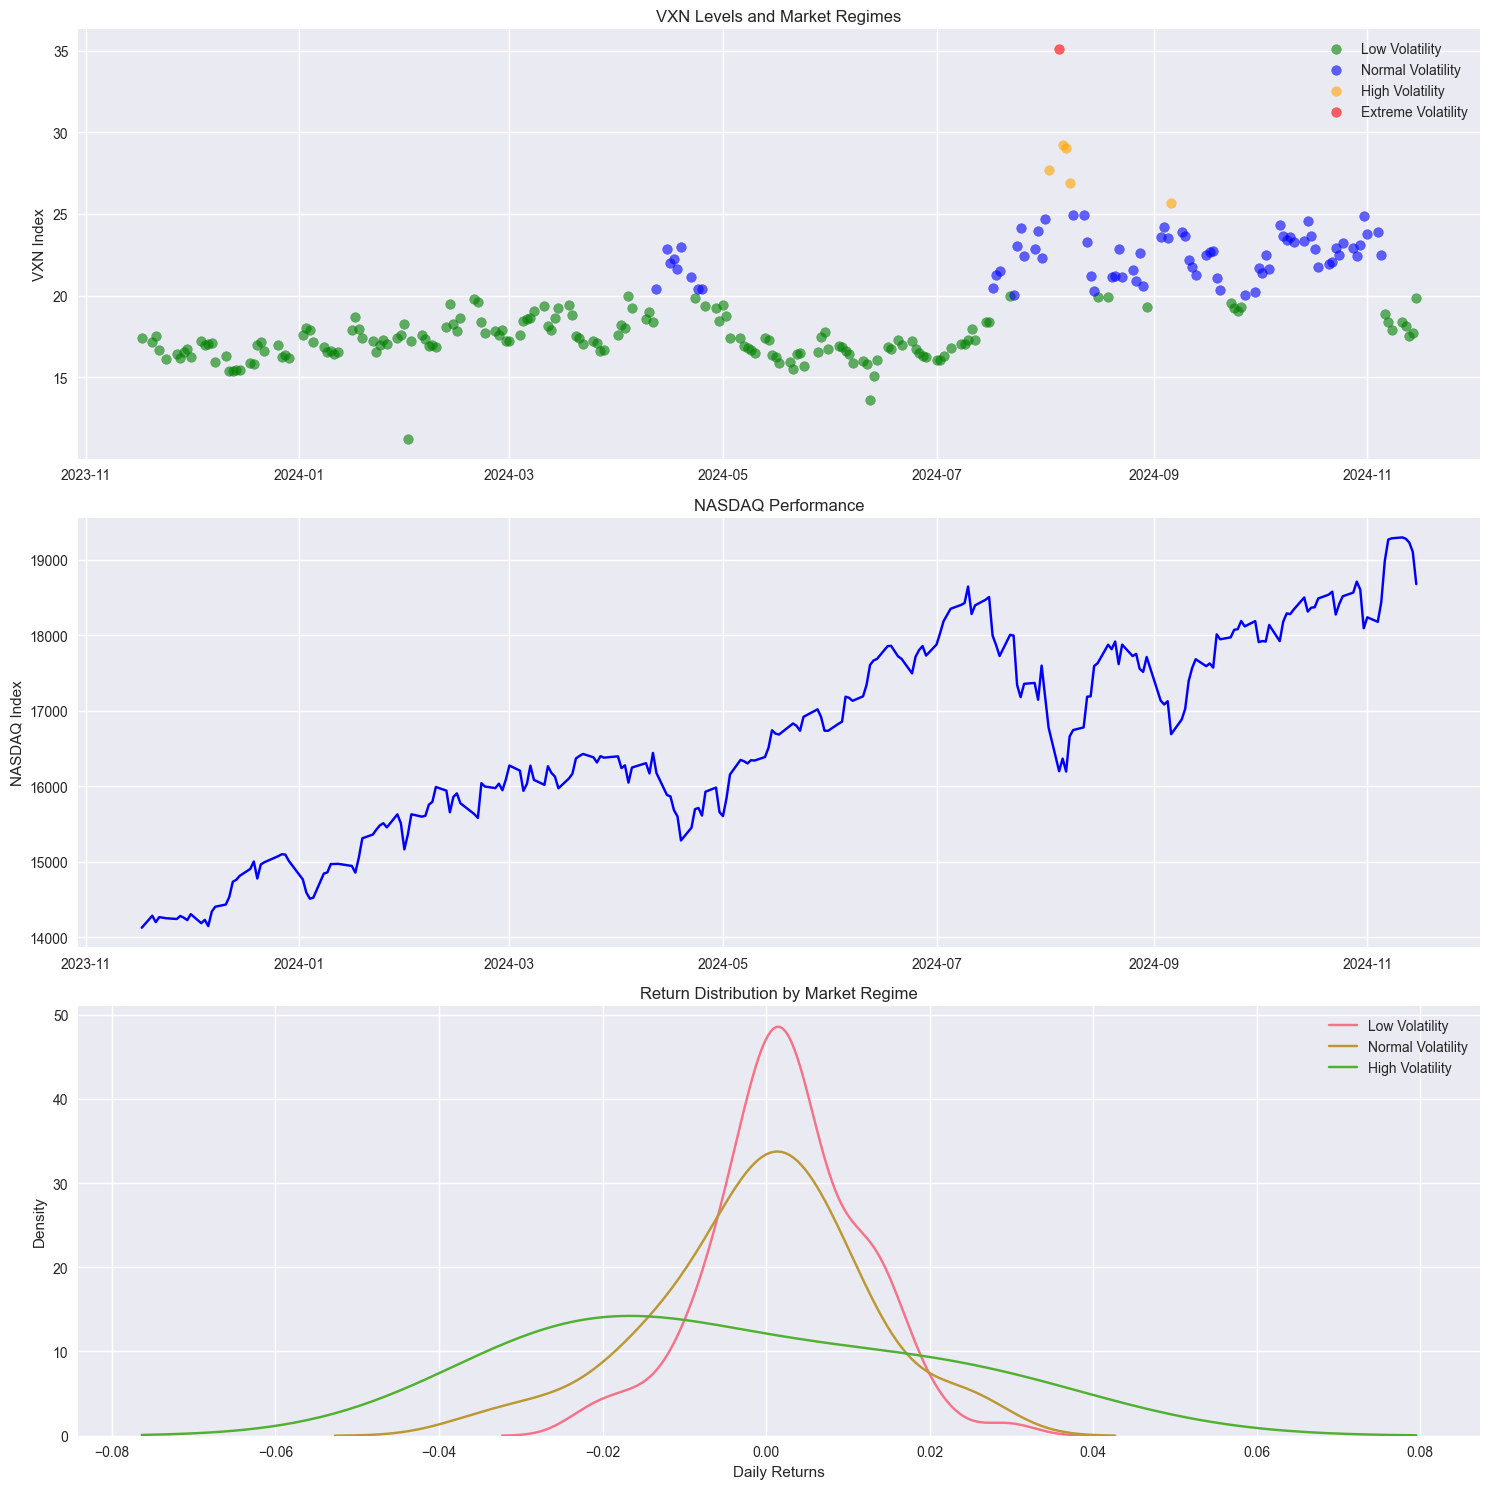

In [47]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: VXN and NASDAQ price
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# VXN plot with regime colors
colors = {
    'Low Volatility': 'green',
    'Normal Volatility': 'blue',
    'High Volatility': 'orange',
    'Extreme Volatility': 'red'}

for regime in colors.keys():
    mask = df['Regime'] == regime
    ax1.scatter(
        df[mask].index, df[mask]['VXN'], 
        c=colors[regime], label=regime, alpha=0.6)

ax1.set_title('VXN Levels and Market Regimes')
ax1.set_ylabel('VXN Index')
ax1.legend()

# NASDAQ plot
ax2.plot(df.index, df['NASDAQ'], color='blue')
ax2.set_title('NASDAQ Performance')
ax2.set_ylabel('NASDAQ Index')

# Returns distribution by regime
for regime in colors.keys():
    mask = df['Regime'] == regime
    sns.kdeplot(data=df[mask]['NASDAQ_Returns'], 
                label=regime, ax=ax3)

ax3.set_title('Return Distribution by Market Regime')
ax3.set_xlabel('Daily Returns')
ax3.legend()

plt.tight_layout()


In [48]:
# Print regime statistics
print("\nMarket Regime Statistics:")
print("========================")
print(regime_stats[['count', 'annualized_return', 'annualized_volatility']])

# Calculate transition probabilities between regimes
transitions = pd.crosstab(df['Regime'].shift(), df['Regime'], normalize='index')
print("\nRegime Transition Probabilities:")
print("==============================")
print(transitions.round(2))

# Calculate average regime duration
regime_changes = (df['Regime'] != df['Regime'].shift()).astype(int)
regime_starts = df.index[regime_changes == 1]
regime_durations = pd.Series(dtype='timedelta64[ns]')

for i in range(len(regime_starts)-1):
    duration = regime_starts[i+1] - regime_starts[i]
    regime_durations = pd.concat([regime_durations, pd.Series([duration])])

print("\nAverage Regime Duration:")
print("=======================")
print(regime_durations.mean().days, "days")




Market Regime Statistics:
                    count  annualized_return  annualized_volatility
Regime                                                             
Extreme Volatility      1            -864.36                    NaN
High Volatility         5            -108.36              37.146348
Low Volatility        169              63.00              14.604547
Normal Volatility      74             -22.68              20.478115

Regime Transition Probabilities:
Regime              Extreme Volatility  High Volatility  Low Volatility  \
Regime                                                                    
Extreme Volatility                 0.0             1.00            0.00   
High Volatility                    0.2             0.40            0.00   
Low Volatility                     0.0             0.00            0.96   
Normal Volatility                  0.0             0.03            0.09   

Regime              Normal Volatility  
Regime                                 


In [49]:
# Additional analysis: Correlation between VXN and NASDAQ returns
correlation = df['VXN'].corr(df['NASDAQ_Returns'])
print(f"\nCorrelation between VXN and NASDAQ returns: {correlation:.2f}")

# Calculate regime stability
regime_stability = 1 - (regime_changes.sum() / len(df))
print(f"\nRegime Stability (percentage of days without regime change): {regime_stability:.2%}")



Correlation between VXN and NASDAQ returns: -0.25

Regime Stability (percentage of days without regime change): 91.60%
